In [4]:
import os
import pandas as pd

# Define folder path
folder_path = "../data/raw/fomc_minutes"

# Initialize list to store data
data = []

# Loop through files
for filename in os.listdir(folder_path):
    if filename.endswith(".txt"):
        file_path = os.path.join(folder_path, filename)

        with open(file_path, "r", encoding="utf-8") as file:
            text = file.read()

        doc_id = filename.replace(".txt", "")
        data.append({"doc_id": doc_id, "text": text})

# Convert to DataFrame
df = pd.DataFrame(data)

# Preview
print(df.head())

                doc_id                                               text
0  FOMCminutes20000202  FRB: FOMC Minutes - February 1-2, 2000\nMinute...
1  FOMCminutes20000321  FRB: FOMC Minutes - March 21, 2000\nMinutes of...
2  FOMCminutes20000516  FRB: FOMC minutes - May 16, 2000\nMinutes of t...
3  FOMCminutes20000628  FRB: FOMC Minutes - June 27-28, 2000\nMinutes ...
4  FOMCminutes20000822  FRB: FOMC Minutes - August 22, 2000\nMinutes o...


In [5]:
!pip install -q scikit-learn pandas matplotlib numpy tqdm
import os, re, glob
import pandas as pd
import numpy as np
from tqdm import tqdm
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt


In [6]:
FOLDER = "../data/raw/fomc_minutes"

files = sorted(glob.glob(os.path.join(FOLDER, "*.txt")))
records = []
date_re = re.compile(r"(\d{4})(\d{2})")       # YYYYMM in filename

for fp in tqdm(files):
    with open(fp, encoding="utf-8") as f:
        txt = f.read()
    m = date_re.search(os.path.basename(fp))
    date = pd.to_datetime(f"{m.group(1)}-{m.group(2)}") if m else pd.NaT
    records.append({"date": date, "text": txt})

df = pd.DataFrame(records).dropna(subset=["date"]).sort_values("date")

# Load stopwords from txt file
with open("../content/Stopwords.txt", "r", encoding="utf-8") as f:
    custom_stopwords = set(word.strip().lower() for word in f if word.strip())

def remove_stopwords(text, stopwords):
    # Tokenize by words (basic split on non-word chars)
    words = re.findall(r"\b\w+\b", text.lower())
    filtered = [w for w in words if w not in stopwords]
    return " ".join(filtered)

# Apply to the DataFrame
df["cleaned_text"] = df["text"].apply(lambda x: remove_stopwords(x, custom_stopwords))

df["text"] = df["cleaned_text"]
df = df.drop(columns=["cleaned_text"])

100%|██████████| 193/193 [00:00<00:00, 1845.91it/s]


In [7]:
vectorizer = TfidfVectorizer(
    max_df=0.9, min_df=10,        # prune very common / very rare
    stop_words="english",
    ngram_range=(1,2)             # unigrams + bigrams often work well for policy text
)
X = vectorizer.fit_transform(df["text"])


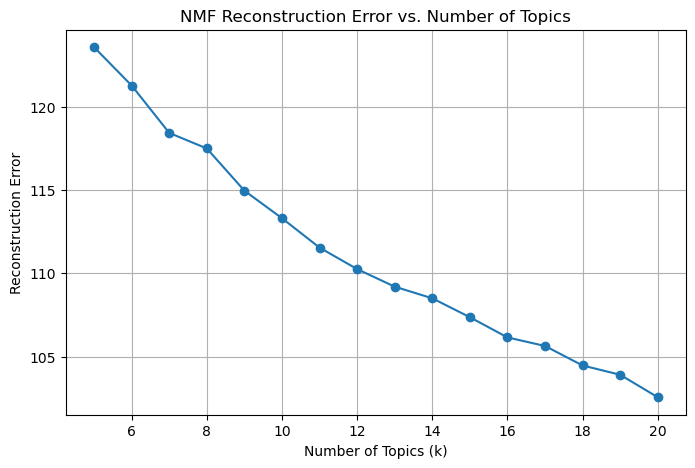

In [8]:
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import numpy as np

# Vectorize
vectorizer = TfidfVectorizer(
    max_df=0.9, min_df=10, stop_words='english', ngram_range=(1, 2)
)
X = vectorizer.fit_transform(df["text"])

# Try topic numbers from 5 to 20
k_values = list(range(5, 21))
errors = []

for k in k_values:
    nmf_model = NMF(
        n_components=k,
        random_state=42,
        init='nndsvda',
        beta_loss='kullback-leibler',
        solver='mu',
        max_iter=500
    )
    W = nmf_model.fit_transform(X)
    error = nmf_model.reconstruction_err_
    errors.append(error)

# Plot reconstruction error
plt.figure(figsize=(8, 5))
plt.plot(k_values, errors, marker='o')
plt.title("NMF Reconstruction Error vs. Number of Topics")
plt.xlabel("Number of Topics (k)")
plt.ylabel("Reconstruction Error")
plt.grid(True)
plt.show()

In [9]:
n_topics = 20
nmf = NMF(
    n_components=n_topics,
    random_state=42,
    init="nndsvda",
    beta_loss="kullback-leibler",
    solver="mu",
    max_iter=500
).fit(X)


In [10]:
terms = np.array(vectorizer.get_feature_names_out())
n_top = 15
topic_keywords = []
for k, topic_vec in enumerate(nmf.components_):
    top_terms = terms[topic_vec.argsort()[-n_top:][::-1]]
    print(f"Topic {k}: ", ", ".join(top_terms))
    topic_keywords.append(", ".join(top_terms))


Topic 0:  purchases, asset purchases, asset, page, page federal, financial stability, program, improvement, longer run, agency, highly accommodative, survey, thresholds, credit, guidance
Topic 1:  mr, messrs, ms, governors mr, september, expansion, august, weakness, inventory, stimulus, equipment, inventories, july, foreseeable, foreseeable future
Topic 2:  foreign currency, currency, currency operations, subcommittee, december, chairman, january, fourth quarter, fourth, position, million, paragraph, arrangements, agreements, authorized
Topic 3:  credit, division board, board division, page, adviser board, participants noted, special adviser, page federal, adviser, target range, financial stability, survey, loans, restrictive, banking
Topic 4:  mr, credit, ms, purchases, agency, programs, asset, mbs, loans, liquidity, purchase, backed, july, messrs, facility
Topic 5:  pandemic, purchases, virus, asset purchases, credit, asset, flow credit, agency, page, support economy, vaccinations, p

In [11]:
doc_topic = normalize(nmf.transform(X), norm="l1")        # rows sum to 1
df_topics = df.copy()
df_topics[[f"T{k}" for k in range(n_topics)]] = doc_topic
df_topics["dominant_topic"] = doc_topic.argmax(axis=1)
df_topics["dom_topic_keywords"] = df_topics["dominant_topic"].map(
    {k:v for k,v in enumerate(topic_keywords)}
)

In [12]:
# monthly mean weight of each topic
monthly = (
    df_topics
    .set_index("date")
    .resample("M")[[f"T{k}" for k in range(n_topics)]]
    .mean()
)

# optional: keep just top X topics to declutter plots
top_overall = np.argsort(monthly.mean().values)[-6:][::-1]   # 6 most salient topics
monthly = monthly[[f"T{k}" for k in top_overall]]
monthly.head()


,T1,T3,T6,T5,T8,T10
date,,,,,,
2000-02-29,1.763840e-06,1.275183e-21,2.532394e-19,1.912123e-21,1.115154e-08,5.610687e-21
2000-03-31,5.123292e-09,1.186419e-21,1.555111e-20,3.564847e-19,1.187196e-12,8.943479e-22
2000-04-30,NaN,NaN,NaN,NaN,NaN,NaN
2000-05-31,4.525869e-07,6.774960e-25,5.850327e-21,6.142806e-22,4.144764e-10,9.688358e-22
2000-06-30,2.917668e-07,1.586059e-22,2.049789e-21,4.974665e-24,3.085102e-09,2.702783e-20


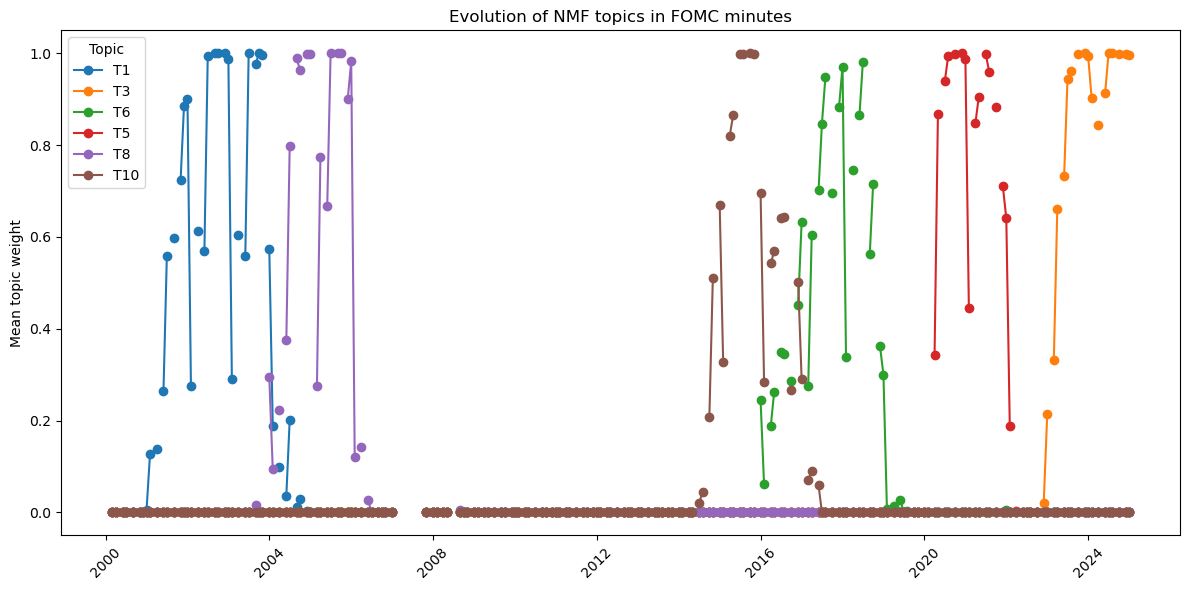

In [13]:
plt.figure(figsize=(12,6))
for col in monthly.columns:
    plt.plot(monthly.index, monthly[col], marker="o", label=col)
plt.legend(title="Topic")
plt.ylabel("Mean topic weight")
plt.title("Evolution of NMF topics in FOMC minutes")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
df_topics.to_csv("FOMC_doc_topics_NMF.csv", index=False)
monthly.to_csv("FOMC_monthly_topic_trends_NMF.csv")

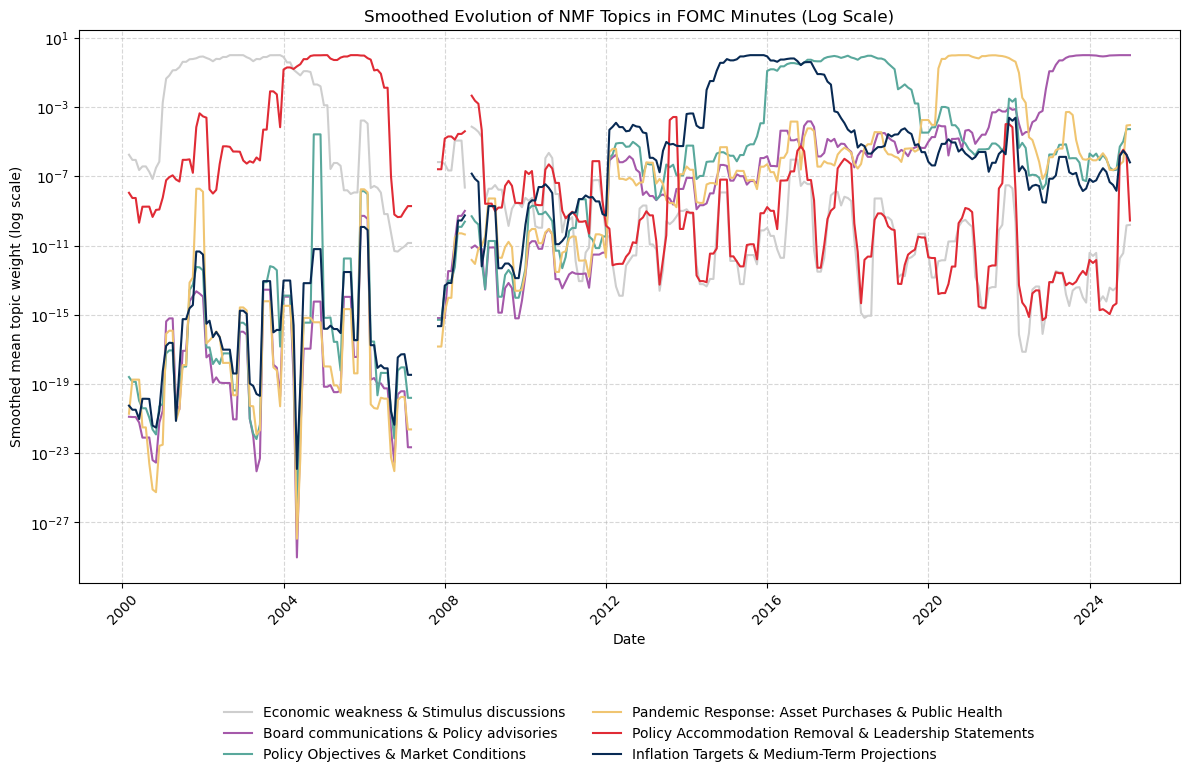

In [26]:
import matplotlib.pyplot as plt
import numpy as np

# 1. Группировка по месяцам и усреднение весов тем
monthly = (
    df_topics
    .set_index("date")
    .resample("M")[[f"T{k}" for k in range(n_topics)]]
    .mean()
)

# 2. Отбор 6 наиболее выраженных тем по среднему значению
top_overall = np.argsort(monthly.mean().values)[-6:][::-1]
monthly = monthly[[f"T{k}" for k in top_overall]]

# 3. Сглаживание скользящим средним по 3 месяцам
monthly_smoothed = monthly.rolling(window=3, min_periods=1).mean()

# 4. Словарь для замены технических имён тем на описательные
topic_labels = {
    "T1": "Economic weakness & Stimulus discussions",
    "T3": "Board communications & Policy advisories",
    "T5": "Pandemic Response: Asset Purchases & Public Health",
    "T6": "Policy Objectives & Market Conditions",
    "T8": "Policy Accommodation Removal & Leadership Statements",
    "T10": "Inflation Targets & Medium-Term Projections"
}

# 5. Цвета для тем (в порядке, соответствующем top_overall)
custom_colors = ['#cecece', '#a559aa', '#59a89c', '#f0c571', '#e02b35', '#082a54']

# 6. Построение графика
plt.figure(figsize=(12, 8))
for i, col in enumerate(monthly_smoothed.columns):
    label = topic_labels.get(col, col)
    plt.plot(monthly_smoothed.index, monthly_smoothed[col], label=label, color=custom_colors[i])

plt.yscale("log")
plt.ylabel("Smoothed mean topic weight (log scale)")
plt.xlabel("Date", labelpad=4)
plt.title("Smoothed Evolution of NMF Topics in FOMC Minutes (Log Scale)")
plt.xticks(rotation=45)
plt.grid(True, which="both", linestyle="--", alpha=0.5)

# Легенда под графиком
plt.legend(
    loc='upper center',
    bbox_to_anchor=(0.5, -0.2),
    ncol=2,
    frameon=False
)

plt.tight_layout()
plt.show()
